# K-Means

In this lab we will implement an application of the K-Means clustering algorithm, the first in our line of unsupervised methods. 

As a reiteration of the core concept, given a set of data points X, meant to be clustered into _k_ groups, the algorithm aims at determining $k$ cluster centers. Subsequently, each point is going to be assinged to a cluster based on the shortest distance towards a cluster center. 

Let $c_i \in \mathbf{R}^n$ denote the center of cluster $i = \overline{1,k}$.

Each data point $x_i \in X$ is going to be assigned to cluster $argmin_j d(x_i, c_j)$, where d is the chosen distance function.

When determining the cluster centers, we start by assigning $k$ random cluster centers within our data distribution. Subsequently, a series of two steps if performed repeatedly until convergence.

1. Expectation - Based on the current centroids, each point is assigned to a cluster.
2. Maximization - Based on the current cluster assignment, each centroid is moved to the center of the cluster it has determined.

The following figure illustrates this process:

![kmeans](./kmeans.png)

The expectation and maximization steps are repeated for a set number of iterations or until the cluster centers have stabilized and no longer update via this procedure.

## Implementation

For this lab we will use the sklearn implementation of the K-Means algorithm. The following is a short usage example.

In [143]:
from sklearn.cluster import KMeans
import numpy as np

# loading the data
X = np.array([
    [1, 2], [1, 4], [1, 0],
    [10, 2], [10, 4], [10, 0]
])

# intantiating the model and fitting the data, similar to previous sklearn models
kmeans = KMeans(n_clusters = 2, random_state = 0).fit(X)
print(kmeans.labels_)
# array([1, 1, 1, 0, 0, 0], dtype=int32)

# using the trained model to make predictions for new data
kmeans.predict([[0, 0], [12, 3]])
# array([1, 0], dtype=int32)

print(kmeans.cluster_centers_)
# array([[10.,  2.], [ 1.,  2.]])

[1 1 1 0 0 0]
[[10.  2.]
 [ 1.  2.]]


## Application

In this lab we will start implementing the pipepline of a large scale unsupervised classification procedure. This method has been proposed by Caron et al in the following ECCV 2018 paper: https://openaccess.thecvf.com/content_ECCV_2018/papers/Mathilde_Caron_Deep_Clustering_for_ECCV_2018_paper.pdf

As described in the paper, the goal is to train a neural network to classify samples without the need for human annotations. In order to do this, the authors propose the exaptation of the expectation-maximization procedure.

They start with a randomly initiallized neural network and perform the following two steps alternatively until convergence:

1. Expectation - (i) the data is passed through the neural network in order to extract features, (ii) the samples are clustered using the k-means algorithm based on the extracted features
2. Maximization - the network is trained to match the labels assigned by the k-means algorithm

We will divide this procedure into steps and implement those steps sequentially.

First we will load the data. For this task we will work with the MNist dataset. The data has been prepared in the mnist folder. In turn this folder contains 3 subfolders: train, val and test. Within each subfolder samples have a filename which follows the pattern {label}\_{sample\_number}.{extension}. That is, in order to determine the label of a given sample, one can simply split the filename based on the '\_' character and convert the first token to int.

As a first task, write the code that reads the data. Complete the 'read_dataset' function, which, given a use case (train, val, test) reads the data from the appropriate folder and returns a numpy array of images and a numpy array of labels for those images. As a preprocessing step, we will normalize the images via division by 255.

In [144]:
from PIL import Image
import pathlib as pb

def preprocess(images: np.ndarray) -> np.ndarray:
    return np.reshape(images, (*images.shape, 1)) / 255.

def read_dataset(use): # use can be 'train', 'val' or 'test'
    filepaths = list(pb.Path('mnist', use).glob('[0-9]_*.png'))
    images = np.stack([np.asarray(Image.open(filepath)) for filepath in filepaths], axis=0)
    labels = np.array([int(filepath.name.split('_')[0]) for filepath in filepaths])
    return preprocess(images), labels

val_images, val_labels = read_dataset('val')
test_images, test_labels = read_dataset('test')
train_images, train_labels = read_dataset('train')

Next, we will define our neural network

Define a convolutional neural network with the following architecture:

- a convolutional layer with 64 filters, kernel size of 5, and relu activation
- a max pooling layer with a size of 2
- a convolutional layer with 64 filters, kernel size of 5, and relu activation
- a max pooling layer with a size of 2
- a flattening layer
- a dense layer with a size of 512 and relu activation with the name 'features'. We name this layer (by specifying name = 'features' in the layer parameters) in order to be able to access its features. We will use those features to perform clustering
- a dense layer with 10 neurons and softmax activation function for classification

Compile the model using the Adam optimizer, a sparse categorical cross-entropy loss and accuracy as an evaluation metric.

In [151]:
import tensorflow as tf

model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(64, 5, activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(64, 5, activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu', name='features'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile('adam', tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.layers

You can test your model the implementation of the model by training it for an epoch on the mnist dataset and noticing its performance on the test set (which should be above 95%).

In [146]:
model.fit(train_images, train_labels, batch_size=32, epochs=1,
          validation_data=(val_images, val_labels), shuffle=True)

1719/1719 [==============================] - 5s 2ms/step - loss: 0.1073 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.0393 - val_sparse_categorical_accuracy: 0.9874


In [147]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9871


[0.039770323783159256, 0.9871000051498413]

Next, we will define a K-Means model with 10 clusters.

In [148]:
kmeans = KMeans(n_clusters=10, random_state=42)

Now that we have defined our prerequisites, we will start the actual procedure. For the expectation step, we will pass the data through the model, taking the output of the second to last layer, and cluster the samples based on those features.

We can get the output of the 'features' layer in tensorflow by defining a new "partial model" which takes inputs the same way the normal model does and outputs the result of the 'features' layer.

In [152]:
partial_model = tf.keras.models.Model(
    inputs = model.input,
    outputs = model.get_layer('features').output
)

Now, we should pass all the training data through the partial model in order to get the features. Iterate through the data passing batches (32 or 64) of samples through the model and collecting the representations for the entire dataset.

Finally, fit the K-Means model on the collected features and get their labels.

For the maximization step, train the neural network for an epoch on the kmeans_features and kmeans_labels. In the interest of time, for this exercise you can shorten the training by specifying steps_per_epoch = 100. 

After implementing the expectation and maximization procedures. It is time to formally evaluate our model. When doing this we should take into account the fact that, the clustering labels are most likely not alligned with the supervised labels. In order to do that, when computing the performance on the test set, we should be careful to match the labels predicted by the network with the test labels.

In [233]:
# Compute number of batches
images = train_images
labels = train_labels
n_batch = 1024
n_steps = 2
n_batches = np.floor(images.shape[0] / n_batch).astype(np.int32)
n_samples = n_batch * n_batches

# Extract samples for mini-batches without remainders
images = images[:n_samples]
dataset = tf.data.Dataset.from_tensor_slices(images)

# Do the process for a couple of steps
for step in range(n_steps):
  # Show current iteration
  print(f'step: [{step} / {n_steps}]')

  # --- Expectation ---
  kmeans_features = []
  for i, imgs in enumerate(dataset.batch(n_batch)):
    # Show current progress
    print(f'batch: [{i} / {n_batches}] - ', end='')

    # Predict features
    features = partial_model.predict(imgs)

    # Collect features
    kmeans_features.append(features)

  # Aggregate all features
  kmeans_features = np.concatenate(kmeans_features, axis=0)
  kmeans_labels = kmeans.fit_predict(kmeans_features)

  # --- Maximization ---
  model.fit(images, kmeans_labels, steps_per_epoch=200, epochs=3)

step: [0 / 2]
32/32 [==============================] - 0s 681us/step
Epoch 1/3
200/200 [==============================] - 1s 3ms/step - loss: 1.3707 - sparse_categorical_accuracy: 0.7564
Epoch 2/3
200/200 [==============================] - 1s 3ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9287
Epoch 3/3
200/200 [==============================] - 1s 3ms/step - loss: 0.1362 - sparse_categorical_accuracy: 0.9462
step: [1 / 2]
32/32 [==============================] - 0s 588us/step
Epoch 1/3
200/200 [==============================] - 1s 3ms/step - loss: 1.5311 - sparse_categorical_accuracy: 0.7204
Epoch 2/3
200/200 [==============================] - 1s 3ms/step - loss: 0.2461 - sparse_categorical_accuracy: 0.9007
Epoch 3/3
200/200 [==============================] - 1s 3ms/step - loss: 0.1944 - sparse_categorical_accuracy: 0.9199


Firstly, iterate through the test dataset in order to get the network predictions for each sample. Due to memory constraints, it is recommended to do this in batches.

In [234]:
predictions = np.argmax(model.predict(test_images, batch_size=n_batch), axis=1)

10/10 [==============================] - 0s 8ms/step


In order to compute the accuracy properly, we have to match the clustering labels with the real labels. We will implement a very straight forwards way of doing this. Computing the confusion matrix, we will assign each cluster to the label with which it has the most predictions in common. That is, a given cluster (predicted label) $i$, will be converted by replacing it with the position of the highest value from column $i$ from the confusion matrix.

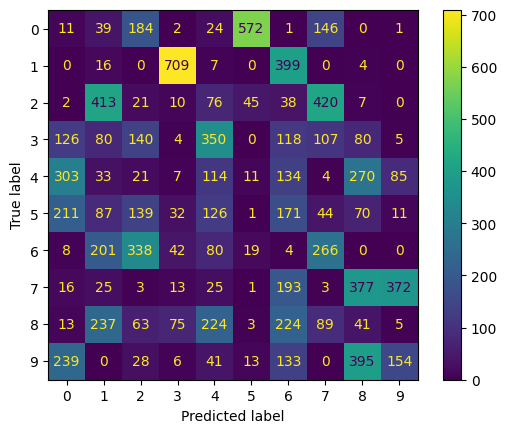

In [244]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


conf_matrix = confusion_matrix(test_labels, predictions)
ConfusionMatrixDisplay(conf_matrix).plot()

In [245]:
mappings = np.argmax(conf_matrix, axis=0)
mappings

array([4, 2, 6, 1, 3, 0, 1, 2, 9, 7])

In [237]:
for i in range(1, mappings.shape[0]):
  if mappings[i] not in mappings[:i]:
    continue

  for j in np.argsort(-conf_matrix[:, i]):
    if j in mappings[:i]:
      continue
    mappings[i] = j

mappings

array([4, 2, 6, 1, 3, 0, 9, 7, 8, 5])

In [246]:
adjusted_predictions = []

# Translate each label
for y_pred in predictions:
  adjusted_predictions.append(mappings[y_pred])

adjusted_predictions = np.array(adjusted_predictions)

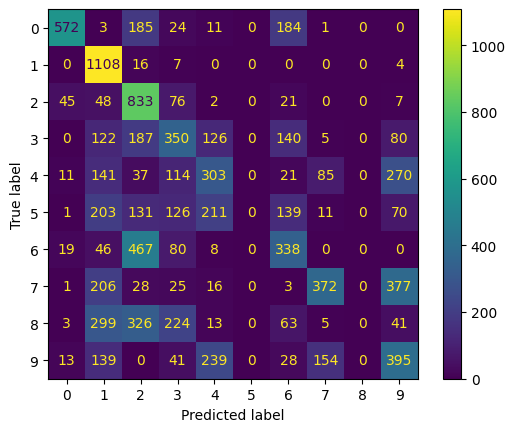

In [247]:
adj_conf_matrix = confusion_matrix(test_labels, adjusted_predictions)
ConfusionMatrixDisplay(adj_conf_matrix).plot()

Finally, evaluate the model by computing the accuracy, comparing the adjusted predictions with the test labels.

In [248]:
acc = adj_conf_matrix.trace() / adj_conf_matrix.sum()
print(acc)

0.4271


As a final task, you can continue the training by looping over the expectation and maximization steps.